In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from extract_features import process_dataset
from imu_pipeline import IMUPipeline


In [14]:
import os
print(os.path.exists("data/manual_annotation/inference_labels.csv"))


True


In [15]:
process_dataset('inference')


Looking for label file at: data\manual_annotation\inference_labels.csv
Label file found ✅

Processing 'inference' dataset...


100%|██████████| 473/473 [00:03<00:00, 126.19it/s]


Processed 473 samples to data/inference.csv


,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,0.058921,0.141937,0.263645,-0.227241,0.490886,-0.411727,-1.269705,17,2.361775,0.016296,...,29,21,383,S910846,v1.2.4,pending,97,5.613430,5g,model_b
1,0.106114,0.269372,1.778952,-0.216834,1.995787,3.211183,15.644389,1,8.382128,0.056256,...,15,58,163,S745147,v1.3.0,pending,60,1.196678,5g,model_b
2,0.789526,2.145882,9.063698,-5.985732,15.049430,0.780326,3.492323,11,522.816335,0.819377,...,32,55,838,S815741,v1.3.0,ok,39,3.882185,wifi,model_b
3,0.608177,1.767987,7.425284,-5.526085,12.951369,0.051386,2.937480,15,349.565584,1.388228,...,24,71,166,S192238,v1.2.3,ok,46,3.886005,wifi,model_b
4,-1.194933,1.703552,5.421388,-5.423952,10.845341,1.637340,4.764184,5,432.995344,-0.195628,...,27,52,720,S146695,v1.2.3,recent,36,7.753421,4g,model_a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,-1.636018,1.836926,6.591974,-9.584012,16.175985,0.312256,7.618219,3,605.085057,1.075774,...,24,75,720,S259109,v1.2.3,ok,76,3.351859,5g,model_b
469,0.060071,0.144546,0.310245,-0.195478,0.505723,-0.337960,-1.312457,13,2.450196,0.015352,...,17,78,945,S852576,v1.2.4,ok,91,6.921099,5g,model_b
470,0.558987,1.950833,8.567100,-4.938564,13.505664,0.908525,4.674787,8,411.821559,-0.130941,...,30,34,574,S639486,v1.2.3,recent,95,8.046290,4g,model_a
471,0.102132,0.273789,1.820321,-0.219719,2.040041,3.268718,16.336809,1,8.539161,0.016576,...,26,23,55,S935107,v1.2.4,ok,76,7.027533,4g,model_a


In [16]:
df_inf = pd.read_csv("data/inference.csv")
labels_inf = pd.read_csv("data/manual_annotation/inference_labels.csv")
df_test = pd.read_csv("data/test.csv")
labels_test = df_test['label']


In [17]:
model = joblib.load("models/imu_pipeline.pkl")

preds_inf = model.predict(df_inf)
probs_inf = model.predict_proba(df_inf)

preds_test = model.predict(df_test.drop(columns='label'))


In [18]:
print(" Inference Classification Report:")
print(classification_report(labels_inf['label'], preds_inf))

print("\n Test Set Classification Report:")
print(classification_report(labels_test, preds_test))


 Inference Classification Report:
              precision    recall  f1-score   support

   collision       0.51      0.83      0.63       236
      normal       0.54      0.20      0.29       237

    accuracy                           0.51       473
   macro avg       0.52      0.51      0.46       473
weighted avg       0.52      0.51      0.46       473


 Test Set Classification Report:
              precision    recall  f1-score   support

   collision       1.00      0.89      0.94       100
      normal       0.90      1.00      0.95       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200



In [19]:
df_inf['label'] = labels_inf['label']
df_test_labeled = df_test.copy()

df_inf['dataset'] = 'inference'
df_test_labeled['dataset'] = 'test'
df_combined = pd.concat([df_inf, df_test_labeled], ignore_index=True)


In [20]:
def plot_signal(sample_id, source='auto'):
    path = f"data/raw/inference/{sample_id}.npz"
    data = np.load(path, allow_pickle=True)
    phone = data['phone_signal']
    camera = data['camera_signal'] if 'camera_signal' in data.files else None

    if source == 'camera' and camera is not None:
        sig, src = camera, 'camera'
    elif source == 'phone' or camera is None:
        sig, src = phone, 'phone'
    else:
        sig, src = camera if camera is not None else phone, 'camera' if camera is not None else 'phone'

    t = np.arange(len(sig))
    plt.plot(t, sig[:, 0], label='X')
    plt.plot(t, sig[:, 1], label='Y')
    plt.plot(t, sig[:, 2], label='Z')
    plt.title(f"Signal: {sample_id} ({src})")
    plt.xlabel("Frame"); plt.ylabel("Accel")
    plt.legend(); plt.grid(); plt.tight_layout()
    plt.show()


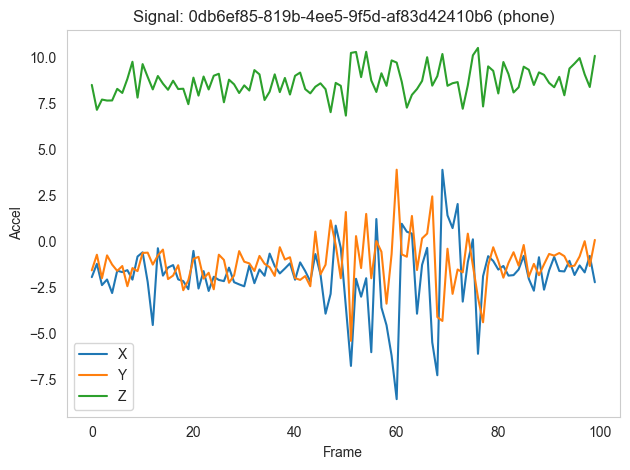

In [21]:
plot_signal("0db6ef85-819b-4ee5-9f5d-af83d42410b6")


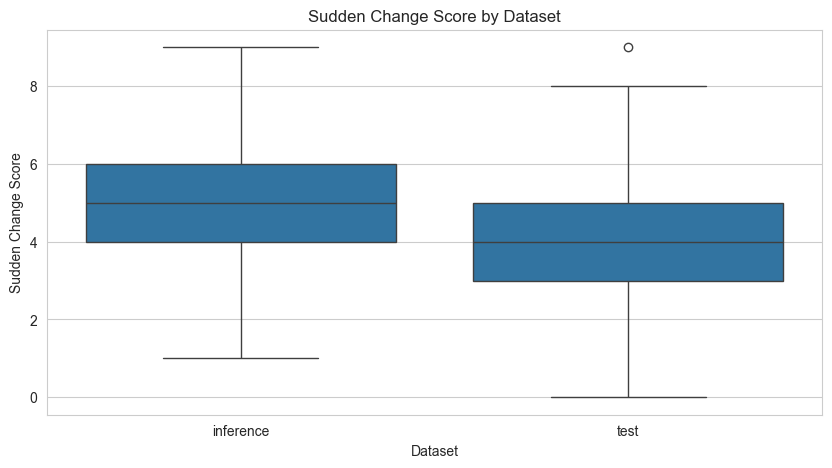

In [22]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_combined, x='dataset', y='sudden_change_score')
plt.title("Sudden Change Score by Dataset")
plt.xlabel("Dataset")
plt.ylabel("Sudden Change Score")
plt.show()


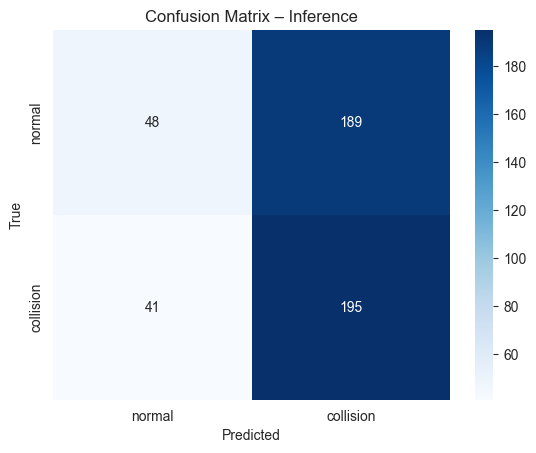

In [23]:
classes = ["normal", "collision"]
cm = confusion_matrix(labels_inf['label'], preds_inf, labels=classes)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.title("Confusion Matrix – Inference")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### ❓ Questions to Reflect On

- What do you observe when comparing the model’s predictions on the new data to its known performance?
- Is there anything in the data that might explain differences in behavior?
- Can you identify patterns or trends related to when the model succeeds or fails?
- Are there signals or features that seem to affect the model’s reliability?
- What could be done in the short term to handle the current situation?
- What are potential long-term steps to improve model performance in similar scenarios?
- What would you want to explore further if given more time or data?
- What assumptions did the model rely on during training — and are they still valid?

---

   Sensor Analysis 

דוגמה תקינה (normal):  
נראה יציב, ללא שינויים בצירים (X, Y, Z). הסיגנל נראה דומה לדוגמאות מסומנות כ־normal.  
המודל פועל נכון לזיהוי תנועה תקינה של הרכיב.

דוגמה חריגה (collision):  
נבחרה דגימה מסומנת כ־collision מתוך התיקייה `cab8d5-926c-417a-bd8a-72d7e3336466`.  
נראה שינוי חד בין שניות 35–40, שמייצג זעזוע או פגיעת פתאומית — כנראה מגע חזק.

מצ"ב תשובות לשאלות במסמך וורד
---
